In [29]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from random import random
from math import *
import sys
np.set_printoptions(threshold=sys.maxsize)


In [30]:
def overlap(c1, c2):
    """Return the area of intersection of two circles.

    The circles have radii R and r, and their centres are separated by d.

    """
    d = np.linalg.norm(c1.center - c2.center)
    r = c1.a
    R = c2.a
    
    if d <= abs(R-r):
        # One circle is entirely enclosed in the other.
        return np.pi * min(R, r)**2
    if d >= r + R:
        # The circles don't overlap at all.
        return 0

    r2, R2, d2 = r**2, R**2, d**2
    alpha = np.arccos((d2 + r2 - R2) / (2*d*r))
    beta = np.arccos((d2 + R2 - r2) / (2*d*R))
    return ( r2 * alpha + R2 * beta -
             0.5 * (r2 * np.sin(2*alpha) + R2 * np.sin(2*beta))
           )

In [203]:
class Neuron:
    
    def __init__(self):
        x = random()
        y = random()
        self.center = np.array([x, y])
        self.a = random()*0.05
        #self.circle = plt.Circle(self.center, self.a, edgecolor='black', fill=False)
        
        self.r = random()*0.0002
        self.C = random()*0.01
        
        self.k = 0.02
        self.g = 0.5
        
        self.taur = 0.2
        
    def step(self, x, dt, D):
        return x+dt*D(x, dt)
    
    def rate(self, x, t):
        return self.taur*(0.0001-x)
    
    def r_fire(self, area):
        self.r += self.g*area
    
    def calcium(self, x, t):
        return -x*0.32
    
    def c_fire(self):
        self.C += 1
    
    def radius(self, x, t):
        return self.k*(0.08-self.C)
    
    def set_k(self, new_k):
        self.k = new_k

    def set_taur(self, new_taur):
        self.k = new_taur        
    
    def set_g(self, new_g):
        self.g = new_g

    def update(self):
        self.a = max(0, self.step(self.a, 1, self.radius))
        self.r = max(0, self.step(self.r, 1, self.rate))
        self.C = max(0, self.step(self.C, 1, self.calcium))
        #self.circle = plt.Circle(self.center, self.a, edgecolor='black', fill=False)


class Network:
    def __init__(self, n):
        self.neurons = np.array([Neuron() for i in range(n)])
        self.A = np.zeros((n, n))
        self.refr = np.zeros(n)
        
        self.update_area()
    
    def update_area(self):
        for i in range(0, self.neurons.size):
            for j in range(i, self.neurons.size):
                if i == j:
                    pass
                else:
                    temp = overlap(self.neurons[i], self.neurons[j])
                    self.A[i, j] = temp
                    self.A[j, i] = temp
        
    def fire(self):
        count = 0
        for i in range(self.neurons.size):
            n = self.neurons[i]
            if self.refr[i] == 0 and np.random.binomial(1, min(n.r, 1)):
                #print("FIRE", i, n.r)
                self.refr[i] = 22
                count += 1
                n.c_fire()
                for j in range(self.neurons.size):
                    if i != j:
                        self.neurons[j].r_fire(self.A[i, j])
        return count
    
    def halt_growth(self):
        for i in range(self.neurons.size):
            n = self.neurons[i]
            n.set_k(0)
#             n.set_taur(1)
            

    def network_update(self):
        for i in range(self.refr.size):
            if self.refr[i] > 0:
                self.refr[i] -= 1
        
        for n in self.neurons:
            n.update()
        
        c = self.fire()
        self.update_area()
        return c

        
            
    
    

<IPython.core.display.Javascript object>


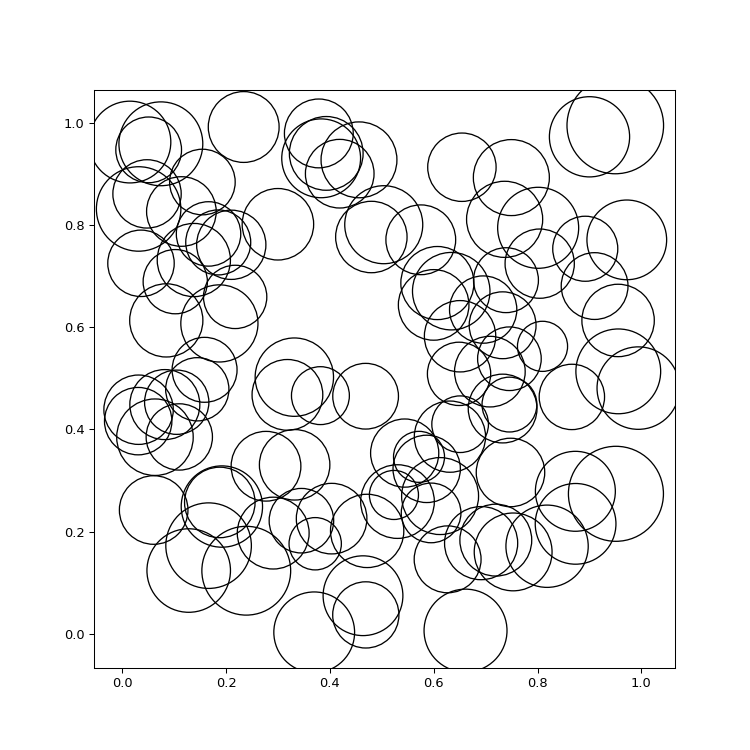

In [204]:
network = Network(100)

pos = np.array([n.center for n in network.neurons])
rad = np.array([n.a*17500 for n in network.neurons])

fig, ax = plt.subplots(figsize=(8, 8))
scat = ax.scatter(pos[:, 0], pos[:, 1], s=rad, edgecolors='black', facecolors='none')
plt.show()

Cs = []
rs = []

def animate(f):
    c = network.network_update()
    Cs.append(network.neurons[0].C)
    rs.append(network.neurons[0].r)
    rad = np.array([n.a*17500 for n in network.neurons])
    scat.set_sizes(rad)
        
animation = FuncAnimation(fig, animate, interval=10)
plt.show()
#animation.save('network.gif', writer='imagemagick')

<IPython.core.display.Javascript object>


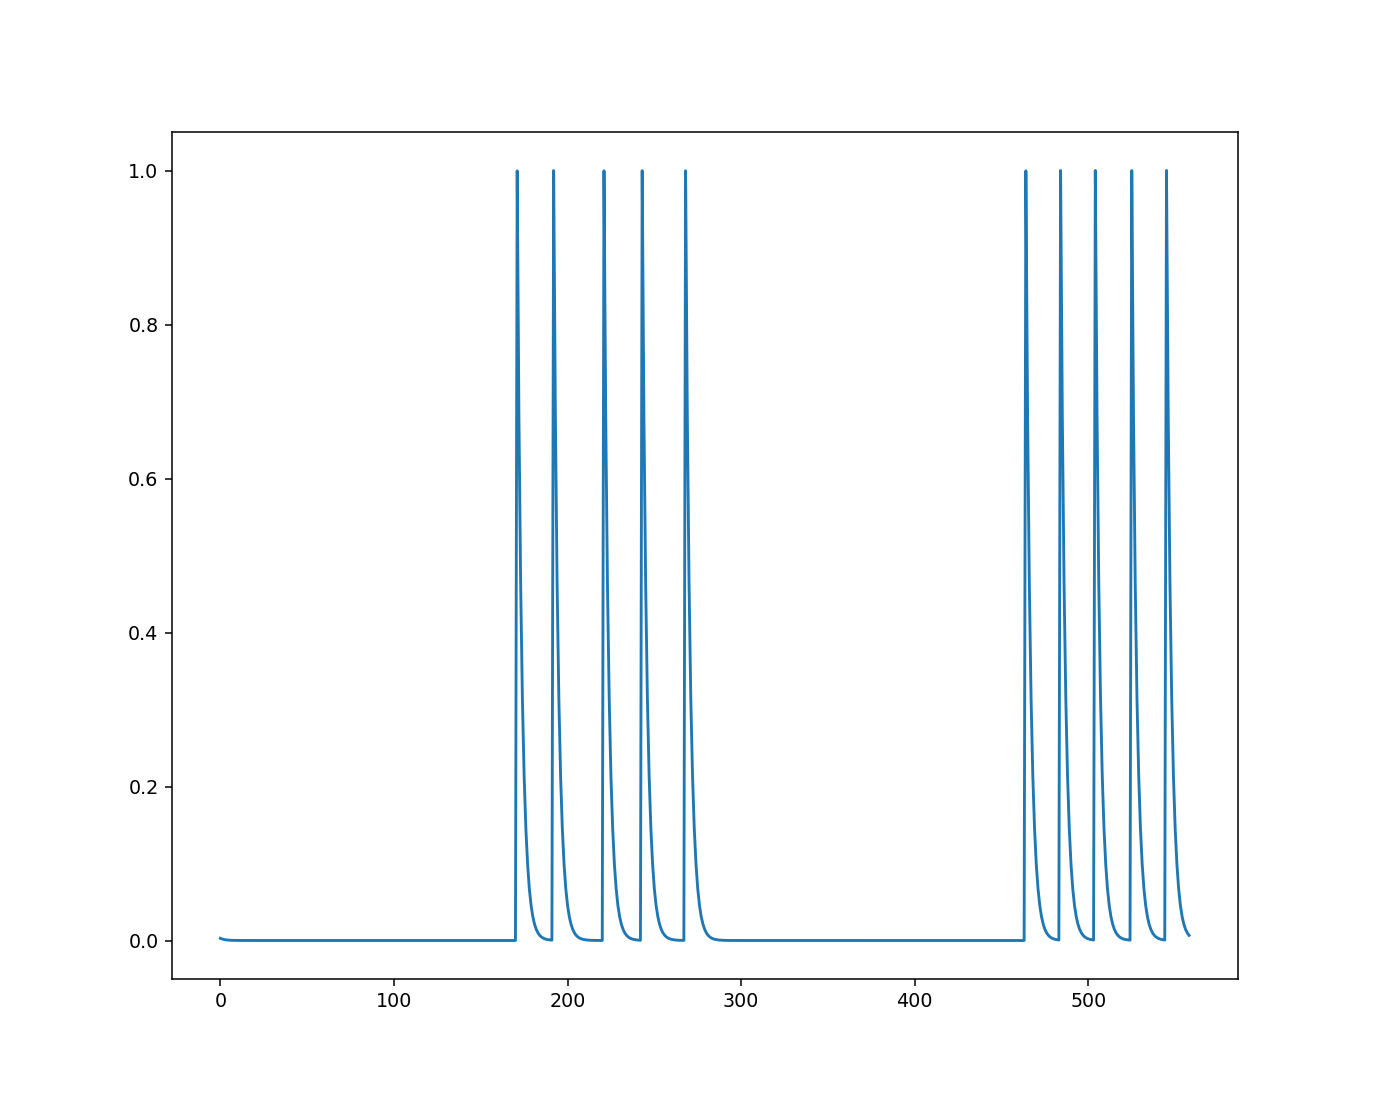

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(Cs)), Cs)
plt.show()

<IPython.core.display.Javascript object>


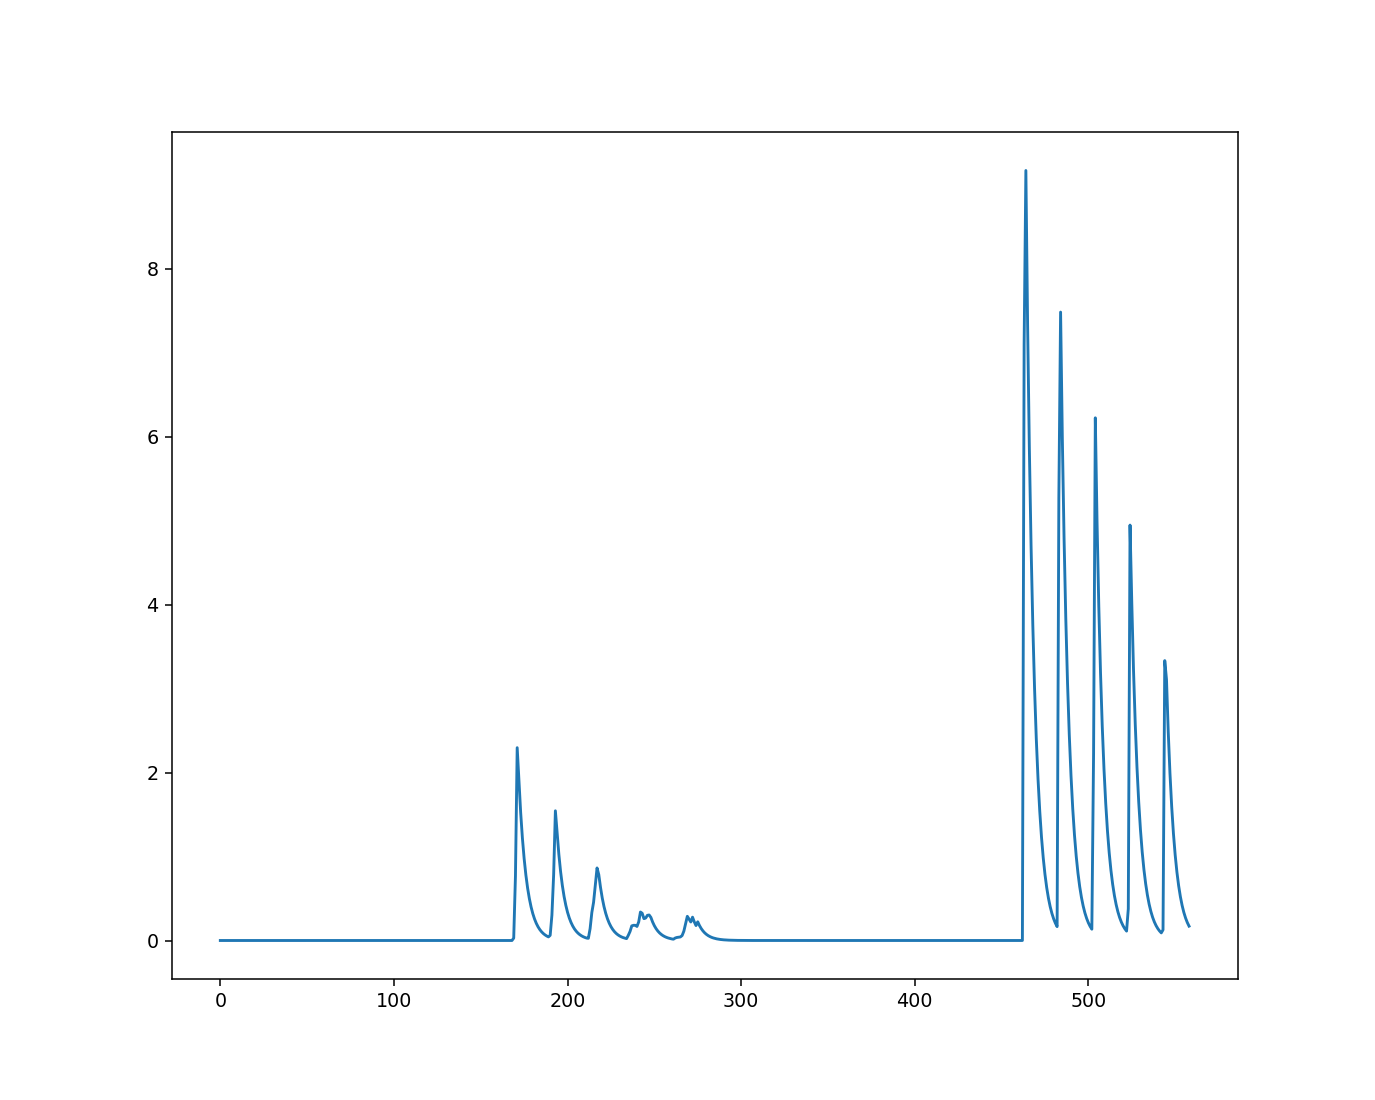

In [43]:
plt.figure(figsize=(10, 8))
plt.plot(range(len(rs)), rs)
plt.show()

In [213]:
def find_avs(avs, network,count = 200, avstop = 2):
    
    network.halt_growth()

    isAv    = 0
    Avlen   = 0
    stoplen = 0
    i = 0

    while len(avs) < count:
        c = network.network_update()
#         print(c)
        if(isAv):

            if(c > 0):
                stoplen =  0
                Avlen   += 1
            else: 
                if stoplen >= avstop:
                    print(len(avs), "save", Avlen)
                    avs.append(Avlen)

                    Avlen   = 0
                    isAv    = 0
                    stoplen = 0

                else:
                    stoplen += 1
        else:
            if(c > 0):
                isAv  = 1
                Avlen = 1


def make_log_plot(set):
    plt.figure(figsize=(8, 4))
    hist , bins = np.histogram(set, bins=10)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    plt.xscale('log')
    plt.hist(set, bins=logbins)
    plt.show()


In [210]:
avs = []
find_avs(avs, network,count = 100, avstop = 1)
len(avs)
print(avs)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
2
0
1
0
3
3
5
3
5
1
1
2
2
0
0
0 save 13
0
0
0
0
0
1
1
1
1
1
1
0
1
1
0
0
1 save 8
1
0
2
0
1
0
0
2 save 3
0
0
1
0
1
3
1
2
1
5
1
2
1
1
0
1
1
1
1
0
2
2
1
0
2
3
0
1
0
0
3 save 21
4
1
2
1
2
3
5
5
2
3
2
7
5
6
3
4
3
1
1
1
2
0
0
4 save 21
0
0
0
0
0
0
1
0
0
5 save 1
1
0
1
1
1
0
3
0
1
0
0
6 save 6
1
1
2
1
0
0
7 save 4
0
0
0
0
0
0
0
1
0
3
1
1
0
0
8 save 4
0
0
0
0
0
0
0
1
0
1
1
0
0
9 save 3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
10 save 2
0
0
1
0
0
11 save 1
2
1
0
3
3
1
1
2
1
1
2
1
0
0
12 save 11
2
1
0
1
1
0
1
0
0
13 save 5
2
0
0
14 save 1
1
0
1
1
0
1
0
0
15 save 4
0
1
0
1
0
1
1
0
0
16 save 4
0
1
0
1
1
0
0
17 save 3
0
3
0
0
18 save 1
0
0
0
0
1
0
0
19 save 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


<IPython.core.display.Javascript object>


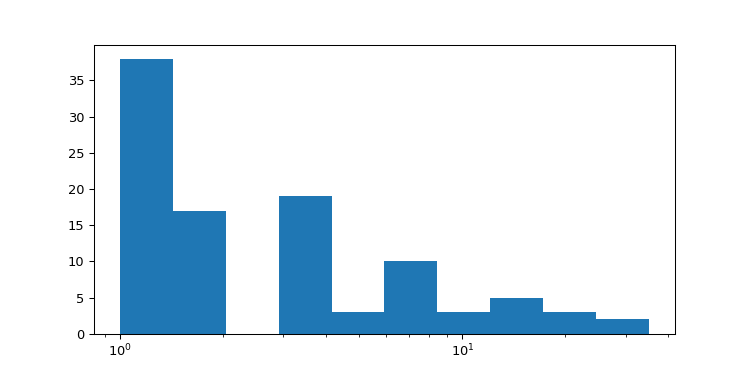

In [211]:
make_log_plot(avs)

0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0 save 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1 save 1
0
0
0
0
0
0
0
0
0
2
0
0
0
2 save 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
3 save 1
0
0
0
1
2
1
0
2
0
2
2
5
1
5
3
3
4
1
0
1
2
0
1
1
0
0
0
4 save 17
0
1
0
0
0
5 save 1
1
0
0
0
6 save 1
0
1
0
0
0
7 save 1
2
0
1
1
0
0
1
2
2
0
0
0
8 save 6
1
1
0
0
0
9 save 2
2
3
1
0
0
0
10 save 3
0
0
0
0
0
0
0
1
2
1
0
1
2
4
1
3
4
1
3
3
0
0
1
2
2
3
2
0
0
1
2
5
2
1
0
2
2
4
0
1
1
3
0
1
0
1
0
1
0
1
0
1
0
0
0
11 save 33
1
0
0
0
12 save 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
0
0
0
13 save 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
1
0
0
0
14 save 2
2
0
2
2
1
3
1
1
1
0
0
0
15 save 8
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
1
0
1
2
0
1
1
3
2
1
2
0
0
0
87 save 11
2
1
1
1
0
1
0
0
0
88 save 5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
89 save 1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
90 save 1
0
0
0
0
0
0
0
0
0
2
0
0
2
2
3
0
1
2
3
2
2
2
3
2
3
0
1
2
0
2
1
2
0
1
0
2
2
3
0
2
3
1
1
3
0
1
0
0
0
91 save 28
0
0
1
0
0
1
1
1
1
1
1
1
2
2
1
0
2
3
0
1
2
0
0
1
1
0
1
1
0
1
2
2
1
2
1
2
2
1
3
4
3
2
4
2
3
5
0
3
2
2
0
0
0
92 save 39
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
1
1
1
3
3
1
0
1
1
0
5
4
0
1

<IPython.core.display.Javascript object>


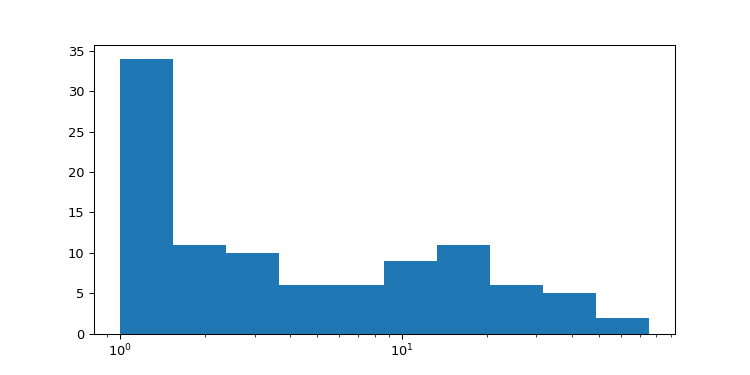

In [212]:
aqs = []
find_avs(aqs, network,count = 100, avstop = 2)
make_log_plot(aqs)

<IPython.core.display.Javascript object>


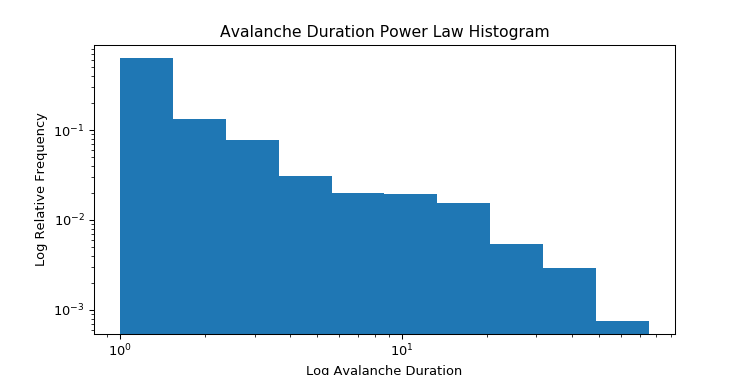

In [221]:

plt.figure(figsize=(8, 4))
hist , bins = np.histogram(aqs, bins=10)
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
plt.xscale('log')
plt.hist(aqs, bins=logbins, density = True, log = True)
plt.xlabel("Log Avalanche Duration")
plt.ylabel("Log Relative Frequency")
plt.title("Avalanche Duration Power Law Histogram")
plt.show()


In [223]:
plt.savefig("AvalancheDuration.png")

In [224]:
import powerlaw

ModuleNotFoundError: No module named 'powerlaw'